In [1]:
# Import libraries
import xarray as xr
import geopandas as gpd
from shapely.geometry import mapping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap, maskoceans
from scipy.interpolate import griddata

In [ ]:
# DAILY MAX HLI

In [2]:
# Import dataset
D_Max_HLI = xr.open_dataset(r'D_Max_HLI.nc')

In [4]:
# Change dataset into a pandas dataframe
D_Max_HLI = D_Max_HLI.to_dataframe()

# Display D_Max_HLI
D_Max_HLI

,latitude,longitude,province_name,time,HLI
index,,,,,
0,-21.0,166.0,None,1994-01-01,89.936264
1,-21.0,166.0,None,1994-01-02,92.363518
2,-21.0,166.0,None,1994-01-03,96.083809
3,-21.0,166.0,None,1994-01-04,91.725319
4,-21.0,166.0,None,1994-01-05,88.079987
...,...,...,...,...,...
7593889,-13.0,171.0,None,2023-12-28,92.107323
7593890,-13.0,171.0,None,2023-12-29,93.660080
7593891,-13.0,171.0,None,2023-12-30,93.186668


In [5]:
# Reset index to move 'time' back to columns
D_Max_HLI.reset_index(drop=True, inplace=True)

# Group by time and province_name to get the average daily maximum HLI for each province
province_daily_max_hli = D_Max_HLI.groupby(['time', 'province_name'])['HLI'].mean().reset_index()


In [6]:
# Display Data
province_daily_max_hli

,time,province_name,HLI
0,1994-01-01,Malampa,91.221458
1,1994-01-01,None,92.771744
2,1994-01-01,Penama,92.576447
3,1994-01-01,Sanma,92.066620
4,1994-01-01,Shefa,93.050537
...,...,...,...
76701,2024-01-01,Penama,91.201538
76702,2024-01-01,Sanma,93.587364
76703,2024-01-01,Shefa,90.958107
76704,2024-01-01,Tafea,89.600945


In [7]:
# Find the number of days each tropical cyclone year that the HLI supassed the threshold of 93 in each Province

# Set the threshold value
threshold = 93

# Create a 'year' column for tropical cyclone years (July-June)
province_daily_max_hli['year'] = province_daily_max_hli['time'].dt.year
province_daily_max_hli.loc[province_daily_max_hli['time'].dt.month < 7, 'year'] -= 1

# Count the number of days each year where the maximum HLI is above the threshold
days_above_threshold = province_daily_max_hli.groupby(['year', 'province_name'])['HLI'].apply(lambda x: (x >= threshold).sum()).reset_index()
days_above_threshold.columns = ['year', 'province_name', 'days_above_threshold']

days_above_threshold

,year,province_name,days_above_threshold
0,1993,Malampa,34
1,1993,None,18
2,1993,Penama,28
3,1993,Sanma,70
4,1993,Shefa,21
...,...,...,...
212,2023,Penama,9
213,2023,Sanma,17
214,2023,Shefa,7
215,2023,Tafea,3


In [8]:
# Get table of 'hot' days

# Pivot the DataFrame so that 'province_name' becomes columns
pivoted_df = days_above_threshold.pivot(index='year', columns='province_name', values='days_above_threshold')

# Display the reshaped DataFrame
pivoted_df

province_name,Malampa,None,Penama,Sanma,Shefa,Tafea,Torba
year,,,,,,,
1993,34,18,28,70,21,10,58
1994,44,29,33,76,25,23,52
1995,63,43,47,103,39,25,79
1996,62,38,60,104,43,25,81
1997,28,26,28,85,25,15,65
1998,93,55,63,139,57,36,100
1999,78,38,48,132,36,31,98
2000,88,58,65,140,55,45,116
2001,75,51,60,128,52,36,107


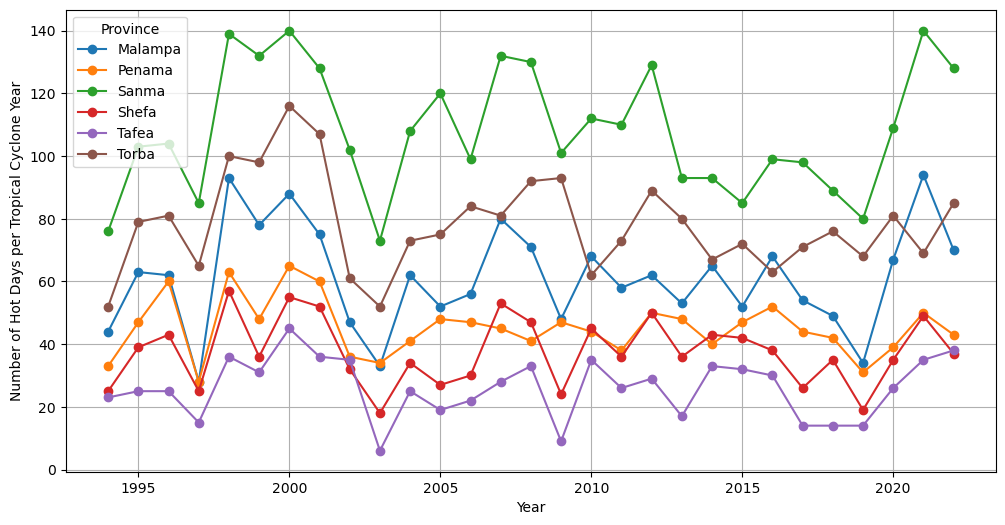

In [9]:
# Plot Hot Days Per TC Year
# Filter the DataFrame
filtered_df = days_above_threshold[
    (days_above_threshold['year'] != 1993) &
    (days_above_threshold['year'] != 2023) &
    (days_above_threshold['province_name'] != 'None')
]

# Plotting
plt.figure(figsize=(12, 6))
for province in filtered_df['province_name'].unique():
    province_data = filtered_df[filtered_df['province_name'] == province]
    plt.plot(province_data['year'], province_data['days_above_threshold'], marker='o', label=province)

plt.xlabel('Year')
plt.ylabel('Number of Hot Days per Tropical Cyclone Year')
plt.legend(title='Province')
plt.grid(True)
plt.show()


In [ ]:
# DAILY MIN HLI

In [19]:
# Import dataset
D_Min_HLI = xr.open_dataset(r'D_Min_HLI.nc')

In [20]:
# Change dataset into a pandas dataframe
D_Min_HLI = D_Min_HLI.to_dataframe()

# Display D_Max_HLI
D_Min_HLI

,latitude,longitude,province_name,time,HLI
index,,,,,
0,-21.0,166.0,None,1994-01-01,59.927830
1,-21.0,166.0,None,1994-01-02,60.758911
2,-21.0,166.0,None,1994-01-03,62.856735
3,-21.0,166.0,None,1994-01-04,62.562931
4,-21.0,166.0,None,1994-01-05,59.359230
...,...,...,...,...,...
7593889,-13.0,171.0,None,2023-12-28,76.118340
7593890,-13.0,171.0,None,2023-12-29,78.640961
7593891,-13.0,171.0,None,2023-12-30,76.737480


In [21]:
# Reset index to move 'time' back to columns
D_Min_HLI.reset_index(drop=True, inplace=True)

# Group by time and province_name to get the average daily maximum HLI for each province
province_daily_min_hli = D_Min_HLI.groupby(['time', 'province_name'])['HLI'].mean().reset_index()

# Display dataset
province_daily_min_hli

,time,province_name,HLI
0,1994-01-01,Malampa,61.995102
1,1994-01-01,None,74.746811
2,1994-01-01,Penama,61.788162
3,1994-01-01,Sanma,63.333183
4,1994-01-01,Shefa,77.736633
...,...,...,...
76701,2024-01-01,Penama,75.984016
76702,2024-01-01,Sanma,71.715096
76703,2024-01-01,Shefa,77.265938
76704,2024-01-01,Tafea,67.619766


In [22]:
# Find the number of days each tropical cyclone year that the HLI was below 77, allowing cattle to cool

# Set the threshold value
threshold = 77

# Create a 'year' column for tropical cyclone years (July-June)
province_daily_min_hli['year'] = province_daily_min_hli['time'].dt.year
province_daily_min_hli.loc[province_daily_min_hli['time'].dt.month < 7, 'year'] -= 1

# Count the number of days each year where the maximum HLI is above the threshold
days_below_threshold = province_daily_min_hli.groupby(['year', 'province_name'])['HLI'].apply(lambda x: (x <= threshold).sum()).reset_index()
days_below_threshold.columns = ['year', 'province_name', 'days_below_threshold']

days_below_threshold

,year,province_name,days_below_threshold
0,1993,Malampa,181
1,1993,None,179
2,1993,Penama,175
3,1993,Sanma,181
4,1993,Shefa,176
...,...,...,...
212,2023,Penama,185
213,2023,Sanma,185
214,2023,Shefa,184
215,2023,Tafea,185


In [23]:
# Get table of 'cool' days

# Pivot the DataFrame so that 'province_name' becomes columns
cool_days = days_below_threshold.pivot(index='year', columns='province_name', values='days_below_threshold')

# Display the reshaped DataFrame
cool_days

province_name,Malampa,None,Penama,Sanma,Shefa,Tafea,Torba
year,,,,,,,
1993,181,179,175,181,176,180,167
1994,365,363,363,365,363,365,353
1995,364,364,363,366,363,366,350
1996,365,363,359,365,357,365,347
1997,362,361,357,365,355,364,336
1998,365,365,363,365,364,365,348
1999,364,366,364,366,363,366,352
2000,365,365,362,365,359,365,351
2001,362,358,356,365,351,365,326


In [10]:
# AHL

In [11]:
# Import dataset

D_Max_AHL = xr.open_dataset(r'D_Max_AHL.nc')

In [13]:
# Change dataset into a pandas dataframe
D_Max_AHL = D_Max_AHL.to_dataframe()

# Display D_Max_HLI
D_Max_AHL

,latitude,longitude,province_name,time,AHL
index,,,,,
0,-21.0,166.0,None,1994-01-01,0.000000
1,-21.0,166.0,None,1994-01-02,0.000000
2,-21.0,166.0,None,1994-01-03,15.414146
3,-21.0,166.0,None,1994-01-04,0.000000
4,-21.0,166.0,None,1994-01-05,0.000000
...,...,...,...,...,...
7593889,-13.0,171.0,None,2023-12-28,0.000000
7593890,-13.0,171.0,None,2023-12-29,1.653564
7593891,-13.0,171.0,None,2023-12-30,1.840233


In [14]:
# Reset index to move 'time' back to columns
D_Max_AHL.reset_index(drop=True, inplace=True)

# Group by time and province_name to get the average daily maximum AHL for each province
province_daily_max_ahl = D_Max_AHL.groupby(['time', 'province_name'])['AHL'].mean().reset_index()

province_daily_max_ahl

,time,province_name,AHL
0,1994-01-01,Malampa,0.000000
1,1994-01-01,None,1.133360
2,1994-01-01,Penama,0.042915
3,1994-01-01,Sanma,0.277927
4,1994-01-01,Shefa,0.767008
...,...,...,...
76701,2024-01-01,Penama,0.000000
76702,2024-01-01,Sanma,17.773657
76703,2024-01-01,Shefa,0.075926
76704,2024-01-01,Tafea,0.000000


In [16]:
# Find the number of days each tropical cyclone year that the AHL supassed the threshold of 50 in each Province

# Set the threshold value
threshold_ahl = 50

# Create a 'year' column for tropical cyclone years (July-June)
province_daily_max_ahl['year'] = province_daily_max_ahl['time'].dt.year
province_daily_max_ahl.loc[province_daily_max_ahl['time'].dt.month < 7, 'year'] -= 1

# Count the number of days each year where the maximum HLI is above the threshold
days_above_threshold_ahl = province_daily_max_ahl.groupby(['year', 'province_name'])['AHL'].apply(lambda x: (x >= threshold_ahl).sum()).reset_index()
days_above_threshold_ahl.columns = ['year', 'province_name', 'days_above_threshold']

days_above_threshold_ahl

,year,province_name,days_above_threshold
0,1993,Malampa,0
1,1993,None,4
2,1993,Penama,4
3,1993,Sanma,0
4,1993,Shefa,2
...,...,...,...
212,2023,Penama,0
213,2023,Sanma,0
214,2023,Shefa,0
215,2023,Tafea,0


In [17]:
# Get table of 'extreme' days

# Pivot the DataFrame so that 'province_name' becomes columns
pivoted_ahl_df = days_above_threshold_ahl.pivot(index='year', columns='province_name', values='days_above_threshold')

# Display the reshaped DataFrame
pivoted_ahl_df

province_name,Malampa,None,Penama,Sanma,Shefa,Tafea,Torba
year,,,,,,,
1993,0,4,4,0,2,0,6
1994,0,0,0,6,0,0,12
1995,0,7,0,1,3,0,5
1996,0,5,0,1,0,0,20
1997,7,30,8,63,5,0,47
1998,0,0,0,0,2,0,2
1999,0,0,0,0,0,0,0
2000,0,0,0,0,2,0,6
2001,3,8,5,5,4,0,30


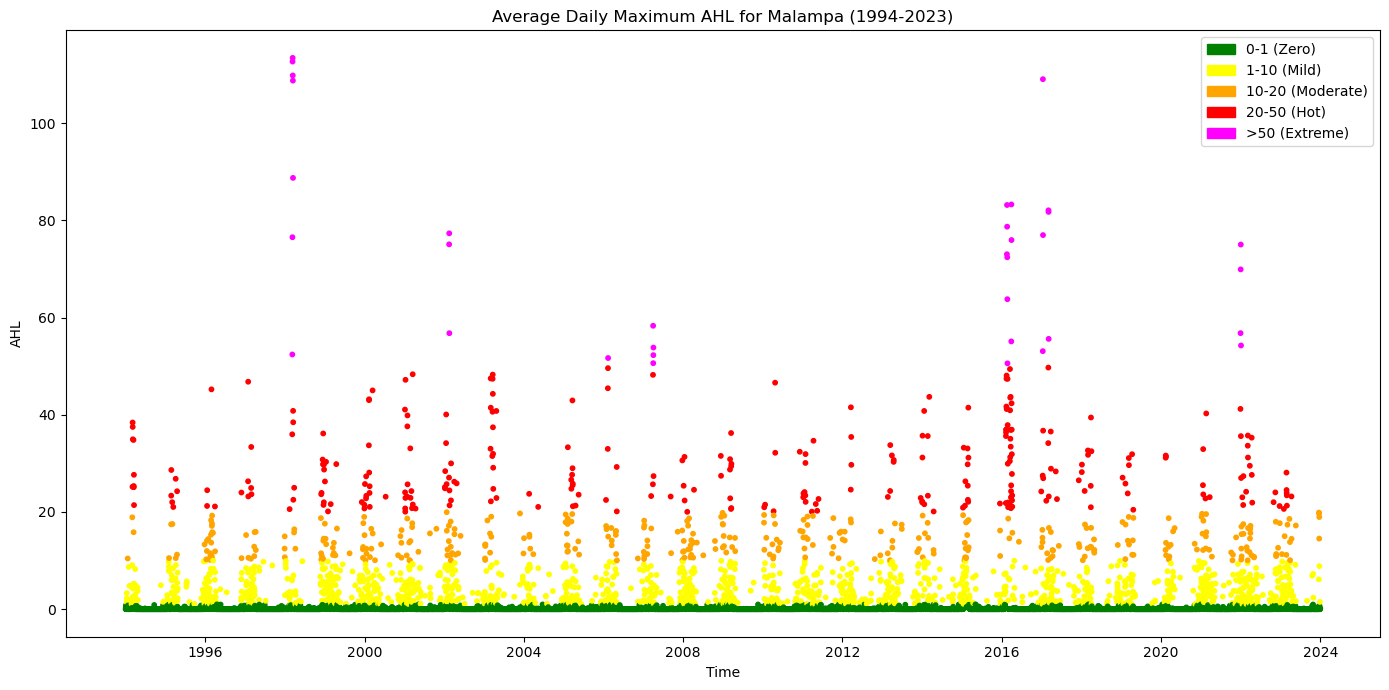

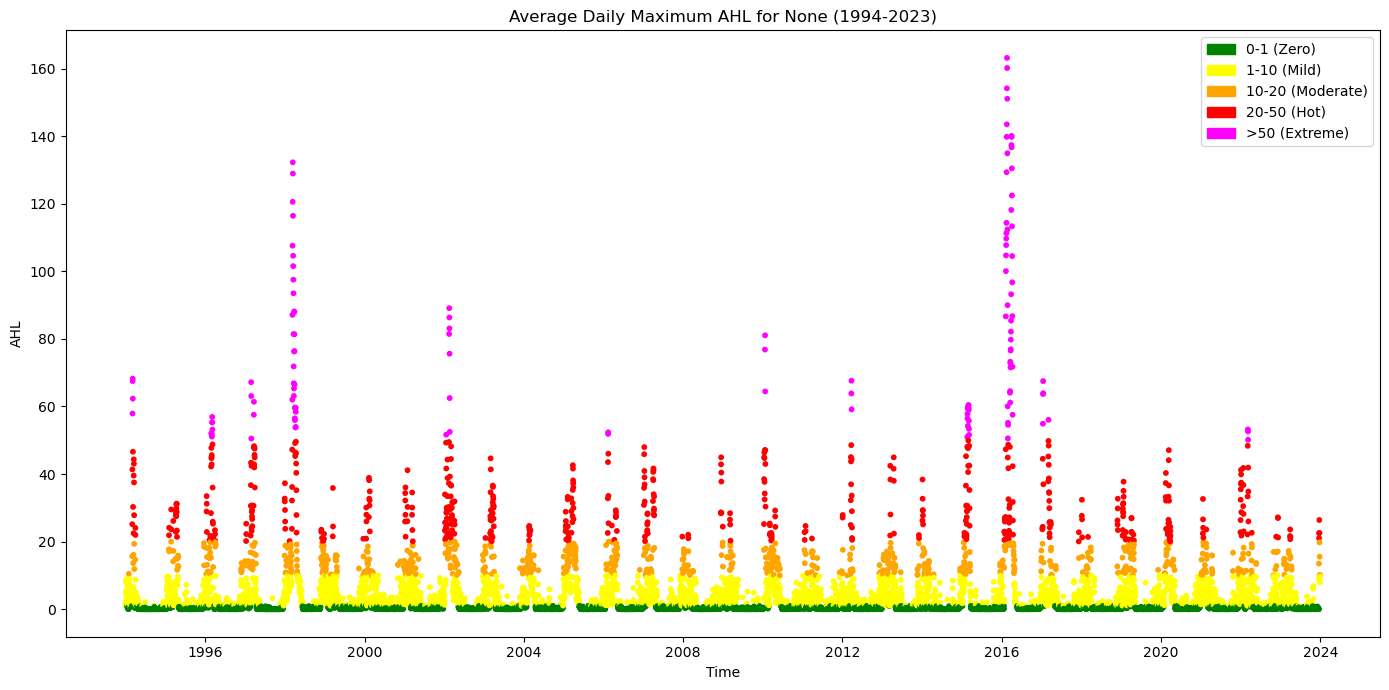

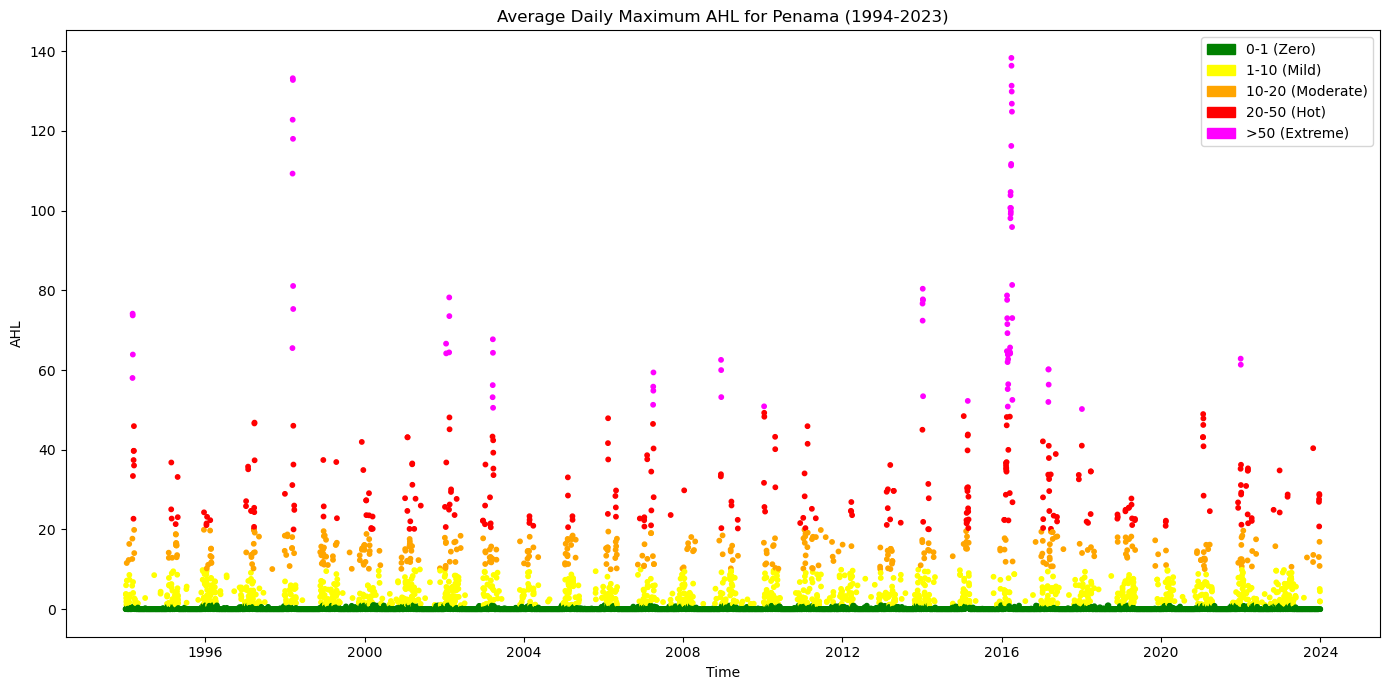

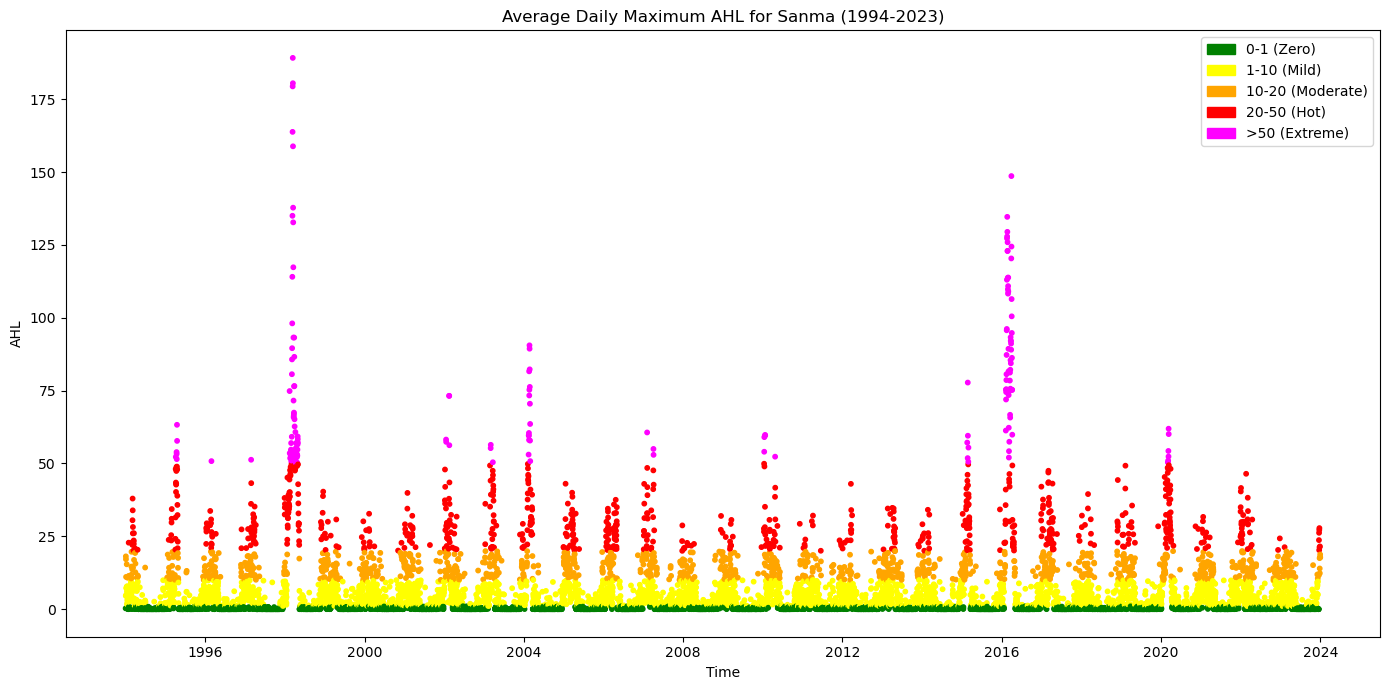

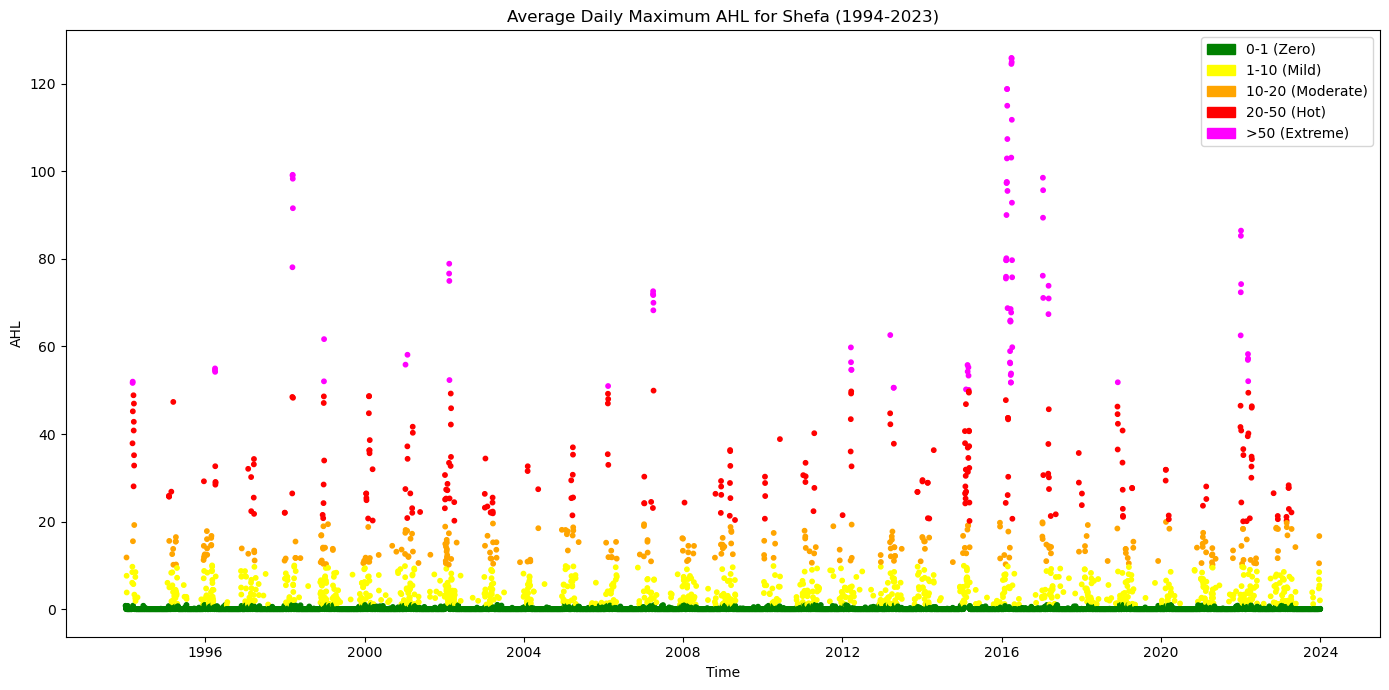

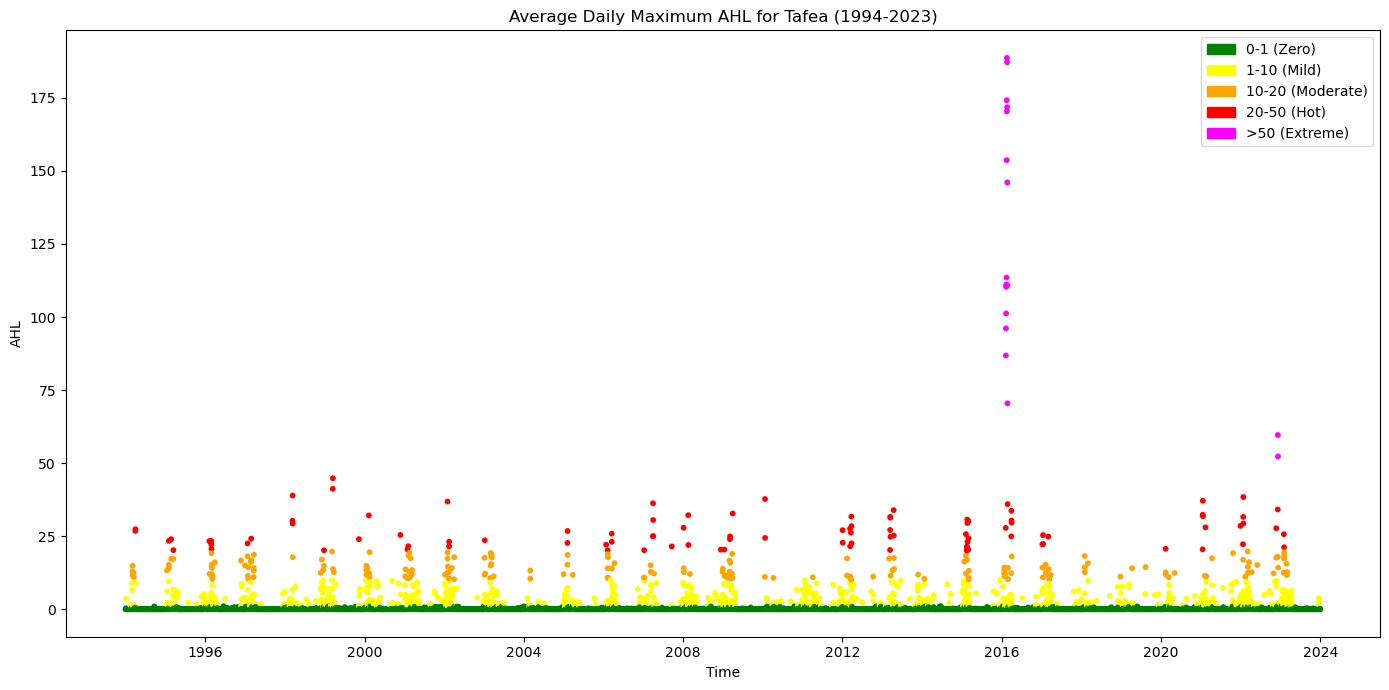

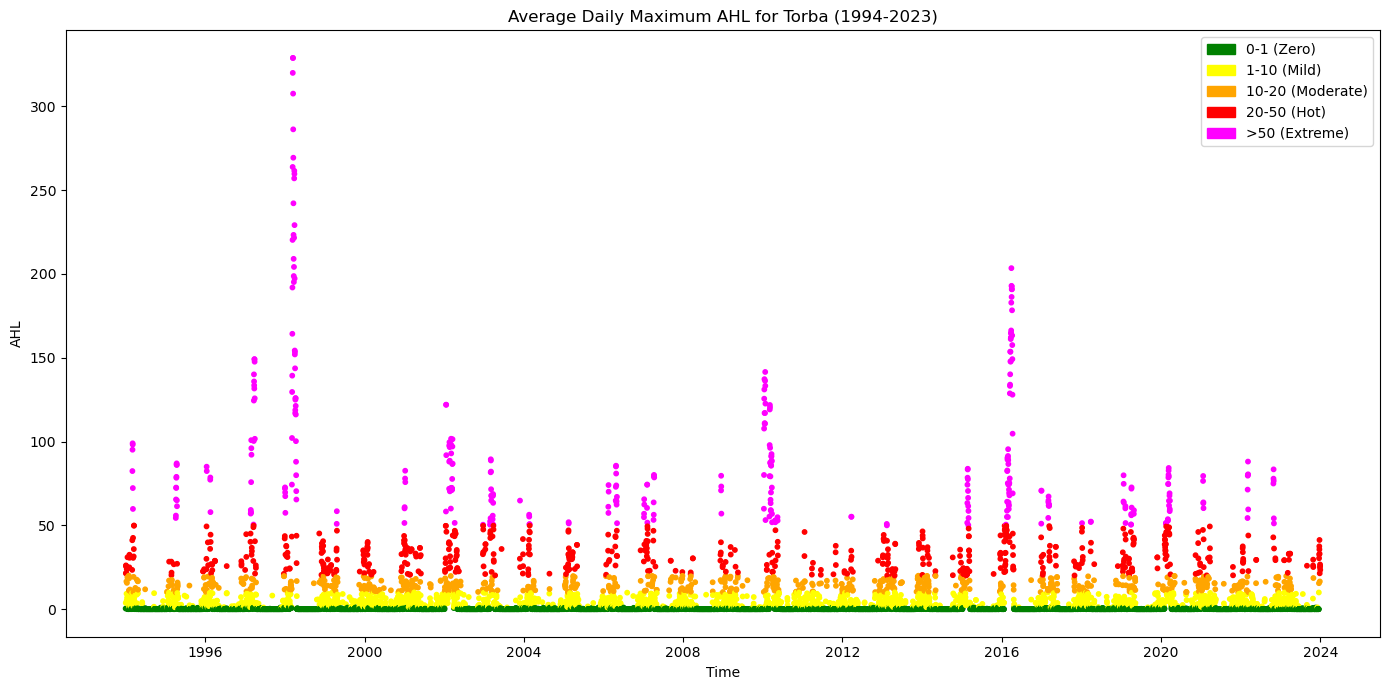

In [18]:
# Plot AHL
# Define categories and corresponding colors
def categorize_ahl(ahl):
    if ahl <= 1:
        return 'green'
    elif 1 < ahl <= 10:
        return 'yellow'
    elif 10 < ahl <= 20:
        return 'orange'
    elif 20 < ahl <= 50:
        return 'red'
    else:
        return 'magenta'

# List of unique provinces
provinces = province_daily_max_ahl['province_name'].unique()

# Plot for each province
for province in provinces:
    plt.figure(figsize=(14, 7))
    
    # Filter data for the current province
    province_data_ahl = province_daily_max_ahl[province_daily_max_ahl['province_name'] == province]
    
    # Apply categorization
    colors = province_data_ahl['AHL'].apply(categorize_ahl)
    
    # Plot monthly maximum AHL with colors based on categories
    plt.scatter(province_data_ahl['time'], province_data_ahl['AHL'], c=colors, label='Daily Max AHL', s=10)

    # Specify custom legend
    plt.legend(handles=[
        mpatches.Patch(color='green', label='0-1 (Zero)'),
        mpatches.Patch(color='yellow', label='1-10 (Mild)'),
        mpatches.Patch(color='orange', label='10-20 (Moderate)'),
        mpatches.Patch(color='red', label='20-50 (Hot)'),
        mpatches.Patch(color='magenta', label='>50 (Extreme)')
    ])

    # Add titles and labels
    plt.title(f'Average Daily Maximum AHL for {province} (1994-2023)')
    plt.xlabel('Time')
    plt.ylabel('AHL')
    plt.tight_layout()
    
    # Show plot
    plt.show()
